In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


country_data = pd.read_csv('data/country.csv',encoding='latin-1')
country_data = country_data.astype(str)
sci_data = pd.read_csv('data/sci.csv',encoding='latin-1').astype(str)
Lat = country_data[['alpha-2','Lat']]
Long = country_data[['alpha-2','Long']]

# merge Lat,Long and SCI datasets
merged = sci_data.merge(Lat,
                            how='left',
                            left_on='user_loc',
                            right_on = 'alpha-2')
merged = merged.merge(Lat,
                        how='left',
                        left_on='fr_loc',
                        right_on='alpha-2',
                        suffixes=('_user','_fr'))
merged = merged.merge(Long,
                      how='left',
                            left_on='user_loc',
                            right_on = 'alpha-2')
merged = merged.merge(Long,
                        how='left',
                        left_on='fr_loc',
                        right_on='alpha-2',
                        suffixes=('_user','_fr'))
merged = merged.drop(columns=['alpha-2_user','alpha-2_fr'])
print(merged.head())


  user_loc fr_loc scaled_sci Migrants_from_fr  Lat_user              Lat_fr  \
0       AE     AE    1318515               ..  24.46667            24.46667   
1       AE     AG       7764               ..  24.46667  17.133329999999997   
2       AE     AL       2836               ..  24.46667            41.33333   
3       AE     AM       4174               ..  24.46667            40.18333   
4       AE     AO       2954               ..  24.46667           -8.833333   

            Long_user              Long_fr  
0  54.416669999999996   54.416669999999996  
1  54.416669999999996  -61.833330000000004  
2  54.416669999999996   19.816670000000002  
3  54.416669999999996                 44.5  
4  54.416669999999996                13.25  


In [2]:
# cleaning data to remove NA values from Lat and Long
merged['Lat_user'] = pd.to_numeric(merged['Lat_user'], errors='coerce')
merged['Lat_fr'] = pd.to_numeric(merged['Lat_fr'], errors='coerce')
merged['Long_user'] = pd.to_numeric(merged['Long_user'], errors='coerce')
merged['Long_fr'] = pd.to_numeric(merged['Long_fr'], errors='coerce')
merged = merged[merged['Lat_user'].notna()]
merged = merged[merged['Lat_fr'].notna()]
merged = merged[merged['Long_user'].notna()]
merged = merged[merged['Long_fr'].notna()]

merged['Lat_user'] = merged['Lat_user'].astype(float)
merged['Lat_fr'] = merged['Lat_fr'].astype(float)
merged['Long_user'] = merged['Long_user'].astype(float)
merged['Long_fr'] = merged['Long_fr'].astype(float)
print(merged.head())


  user_loc fr_loc scaled_sci Migrants_from_fr  Lat_user     Lat_fr  Long_user  \
0       AE     AE    1318515               ..  24.46667  24.466670   54.41667   
1       AE     AG       7764               ..  24.46667  17.133330   54.41667   
2       AE     AL       2836               ..  24.46667  41.333330   54.41667   
3       AE     AM       4174               ..  24.46667  40.183330   54.41667   
4       AE     AO       2954               ..  24.46667  -8.833333   54.41667   

    Long_fr  
0  54.41667  
1 -61.83333  
2  19.81667  
3  44.50000  
4  13.25000  


In [3]:
#calculating the distance between (Lat_user, Long_user) and (Lat_fr, Long_fr)
#https://gist.github.com/rochacbruno/2883505
def distance(s_lat, s_lng, e_lat, e_lng):
    
    # approximate radius of earth in km
    R = 6373.0
    
    s_lat = s_lat*np.pi/180.0                      
    s_lng = np.deg2rad(s_lng)     
    e_lat = np.deg2rad(e_lat)                       
    e_lng = np.deg2rad(e_lng)  
    
    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2
    
    return 2 * R * np.arcsin(np.sqrt(d)) 


In [4]:
#calling the above function to find the distance between user and fr countries
merged["distance_between"] = distance( merged["Lat_user"], merged["Long_user"], 
                                     merged["Lat_fr"], merged["Long_fr"] )
print(merged)

      user_loc fr_loc scaled_sci Migrants_from_fr  Lat_user     Lat_fr  \
0           AE     AE    1318515               ..  24.46667  24.466670   
1           AE     AG       7764               ..  24.46667  17.133330   
2           AE     AL       2836               ..  24.46667  41.333330   
3           AE     AM       4174               ..  24.46667  40.183330   
4           AE     AO       2954               ..  24.46667  -8.833333   
...        ...    ...        ...              ...       ...        ...   
34218      nan     WS       1411               .. -22.56667 -13.800000   
34221      nan     ZA      88866             7872 -22.56667 -25.730000   
34222      nan     ZM     137582             2806 -22.56667 -15.466670   
34223      nan     ZW     326749            13413 -22.56667 -17.833330   
34224      nan    nan  115262823               .. -22.56667 -22.566670   

       Long_user    Long_fr  distance_between  
0       54.41667   54.41667      3.537726e-13  
1       54.4166

In [5]:
#checking if distance between has any NaN values 
#returns false so no NaN values
merged.isnull().values.any()

False

In [6]:
#checking if "distance between" returns 0 for all user_fr pairs that are the same country for eg AG and AG
merged[merged["distance_between"] == 0]

,user_loc,fr_loc,scaled_sci,Migrants_from_fr,Lat_user,Lat_fr,Long_user,Long_fr,distance_between
186,AG,AG,939431362,..,17.133330,17.133330,-61.83333,-61.83333,0.0
372,AL,AL,17636900,..,41.333330,41.333330,19.81667,19.81667,0.0
558,AM,AM,17773786,..,40.183330,40.183330,44.50000,44.50000,0.0
744,AO,AO,18876926,..,-8.833333,-8.833333,13.25000,13.25000,0.0
1116,AT,AT,9622397,..,48.216670,48.216670,16.36667,16.36667,0.0
...,...,...,...,...,...,...,...,...,...
32550,VC,VC,838717398,..,13.200000,13.200000,-61.23333,-61.23333,0.0
32736,VN,VN,879647,..,21.016670,21.016670,105.86670,105.86670,0.0
32922,VU,VU,335385083,..,-17.750000,-17.750000,168.30000,168.30000,0.0
33108,WS,WS,248251473,..,-13.800000,-13.800000,171.75000,171.75000,0.0


In [7]:
#converting sci values to float
merged["scaled_sci"] = merged["scaled_sci"].astype(float)
print(type(merged["scaled_sci"][0]))

<class 'numpy.float64'>


In [8]:
#extracting required data 
corr_data = merged[["user_loc", "fr_loc", "scaled_sci", "distance_between"]]
print(corr_data)

      user_loc fr_loc   scaled_sci  distance_between
0           AE     AE    1318515.0      3.537726e-13
1           AE     AG       7764.0      1.170472e+04
2           AE     AL       2836.0      3.700501e+03
3           AE     AM       4174.0      1.977927e+03
4           AE     AO       2954.0      5.801638e+03
...        ...    ...          ...               ...
34218      nan     WS       1411.0      1.512311e+04
34221      nan     ZA      88866.0      1.181707e+03
34222      nan     ZM     137582.0      1.414124e+03
34223      nan     ZW     326749.0      1.547517e+03
34224      nan    nan  115262823.0      3.537726e-13

[28561 rows x 4 columns]


In [9]:
#using ranksums to get Wilcoxon Rank Sum Test p value on two samples: scaled_sci and abs_diff_gdp
from scipy.stats import ranksums
ranksums(corr_data["scaled_sci"], corr_data["distance_between"])

RanksumsResult(statistic=-97.83020505766947, pvalue=0.0)

In [10]:
#using spearmanr to get the spearman coeffecient of the two samples
from scipy.stats import spearmanr
sp_coef = spearmanr(corr_data["scaled_sci"], corr_data["distance_between"])
print(sp_coef)

SpearmanrResult(correlation=-0.5160371178763786, pvalue=0.0)


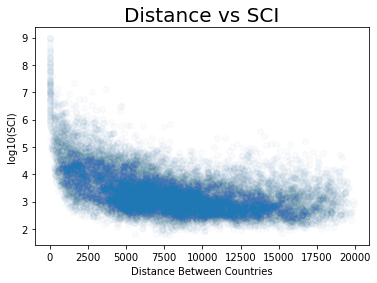

In [11]:
# add a column for the log10(SCI)
merged['scaled_sci'] = pd.to_numeric(merged['scaled_sci'], errors='coerce')
merged['SCI_log10'] = np.log10(merged['scaled_sci'])

plt.scatter(merged['distance_between'], merged['SCI_log10'], alpha = 0.01)
plt.xlabel('Distance Between Countries')
plt.ylabel('log10(SCI)')
plt.title('Distance vs SCI', fontsize=20)
plt.show()